In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.core.frame import DataFrame
from scipy import stats

In [2]:
data = pd.read_csv('data\\data.csv', sep=';')
data.head()

,Z1-4,Z5A,Z5B,Z6I,Z6IIA,Z6IIB,Z7A,Z7B,Z8A,Z8B,Z9A,Z9B,Z10A,Z10B,Z11,Z12,Z13,"Z14,15,16_x","Z14,15,16_y",Unnamed: 19
0,122.3,152.0,158.8,B,133.7,131.6,168.3,172.2,54.9,76.3,85.8,154.7,24.7,27.7,103.3,100.7,118.5,120.6,84.4,NaN
1,117.9,161.4,159.2,B,170.7,157.0,173.2,154.7,50.9,60.9,134.8,137.2,18.4,20.4,93.9,91.5,122.4,124.2,76.9,NaN
2,118.0,140.1,151.5,B,169.2,155.3,186.1,167.4,28.2,66.2,174.0,146.7,29.5,30.4,96.3,96.5,120.4,126.2,82.3,NaN
3,124.0,147.0,160.4,B,163.1,148.2,160.7,176.6,54.2,89.9,177.9,142.9,30.2,25.8,92.2,94.3,117.9,127.6,80.0,NaN
4,126.5,150.6,152.2,B,144.1,143.4,177.9,160.7,42.7,68.9,163.4,136.3,20.7,26.0,97.4,104.7,120.3,128.9,76.7,NaN


# Проверка гипотезы о типе распределения

## Критерий согласия хи-квадрат

Требуется проверить гипотезу $H_0$ о том, что она пренадлежит заданому семейству распределения (нормальному, экспоненциальному или равномерному)

In [3]:
def crit_chi2(data: np.array, r: int=9, alp: float=0.1, distn: str='norm'):
    """
    Критерий согласия Хи-квадрат
    Args:
        data: данные
        r: количество интервалов
        alp: уровень значимости
        dist (norm, exp, uniform): тип семейства для проверки гипотезы
    """    
    data.sort()
    n = data.shape[0]
    data_mean = data.mean()
    data_std = data.std()
    data_min = data.min()
    data_max = data.max()
    
    if distn == 'norm':
        cdf_func = stats.norm.cdf
        cdf_params = (data_mean, data_std)
        m = 2
    elif distn == 'exp':
        cdf_func = stats.expon.cdf
        cdf_params = (0, data_mean)
        m = 1
    elif distn == 'uniform':
        cdf_func = stats.uniform.cdf
        cdf_params = (data_min, data_max)
        m = 0
    else:
        raise Exception('Distribution should be like norm, exp, uniform!')
    
    inter = np.linspace(data_min, data_max, r)
    freqs = [sum(data < inter[0])]
    probs = [cdf_func(inter[0], *cdf_params)]
    for i in range(1, r):
        freqs.append(sum(np.all((inter[i-1] <= data, data < inter[i]), axis=0)))
        probs.append(cdf_func(inter[i], *cdf_params))
    freqs.append(sum(inter[-1] <= data))
    probs.append(1)
    
    # n * p_i
    theor_freqs = [n * (probs[i] - probs[i-1]) for i in range(1, r + 1)]
    hi2_stat = sum([((freqs[i+1] - theor_freqs[i]) ** 2) / theor_freqs[i] for i in range(r)])
    alp_r_1 = 1 - stats.chi2.cdf(hi2_stat, df=r - 1)
    alp_r_m = 1 - stats.chi2.cdf(hi2_stat, df=r - 1 - m)
    
    print(f"Уровень значимости: {alp}")
    print(f"Интервал p-value: [{alp_r_m}, {alp_r_1}]")
    if alp_r_m <= alp and alp <= alp_r_1:
        print('Невозможно сделать вывод о распределении данных!')
    elif alp < alp_r_m:
        print(f'Данные распределены {distn}, гипотеза H0 не отклоняется!')
    else:
        print(f'Данные распределены не {distn}, гипотеза H0 отклоняется!')

In [4]:
X_data = data['Z1-4'].to_numpy()
X_data = X_data[~np.isnan(X_data)]

crit_chi2(X_data, r=9, alp=0.1)
print('')
print('Пример для сгенерированного exp:')
crit_chi2(np.random.exponential(5, 100), r=9, alp=0.1, distn='exp')
print('')
print('Пример для сгенерированного uniform:')
crit_chi2(np.random.uniform(0, 5, 100), r=9, alp=0.1, distn='uniform') 

Уровень значимости: 0.1
Интервал p-value: [0.3412345204340306, 0.560049043717947]
Данные распределены norm, гипотеза H0 не отклоняется!

Пример для сгенерированного exp:
Уровень значимости: 0.1
Интервал p-value: [0.9258225819329744, 0.9609403661284361]
Данные распределены exp, гипотеза H0 не отклоняется!

Пример для сгенерированного uniform:
Уровень значимости: 0.1
Интервал p-value: [0.7348741903587148, 0.7348741903587148]
Данные распределены uniform, гипотеза H0 не отклоняется!


## Критерий согласия Колмогорова (Колмогорова-Смирнова)

Для выборки X(n) ∼ F требуется проверить гипотезу H0 : F = G о том, что функция распределения выборочных данных совпадает с заданным распределением G.

In [5]:
def crit_kolmogorov(data: np.array, alp: float=0.1, distn: str='norm'):
    """
    Критерий согласия Колмогорова
    Args:
        data: данные
        alp: уровень значимости
        dist (norm, exp, uniform): тип семейства для проверки гипотезы
    """
    data.sort()
    n = data.shape[0]
    data_mean = data.mean()
    data_std = data.std()
    data_min = data.min()
    data_max = data.max()
    
    if distn == 'norm':
        cdf_func = stats.norm.cdf
        cdf_params = (data_mean, data_std)
        m = 2
    elif distn == 'exp':
        cdf_func = stats.expon.cdf
        cdf_params = (0, data_mean)
        m = 1
    elif distn == 'uniform':
        cdf_func = stats.uniform.cdf
        cdf_params = (data_min, data_max)
        m = 0
    else:
        raise Exception('Distribution should be like norm, exp, uniform!')
    
    x_edf, y_edf = [data[0]], [0]
    for i in range(1, len(data)):
        f_n = sum(data < data[i]) / n
        x_edf.append(data[i - 1])
        y_edf.append(f_n)
        
        x_edf.append(data[i])
        y_edf.append(f_n)
    #x_edf.append(data[-1])
    #y_edf.append(1)
    
    cdf = cdf_func(data, *cdf_params)
    
    D = abs(np.array(y_edf[::2]) - np.array(cdf))
    arg_delta = np.argmax(D)
    D = D[arg_delta]
    
    arg_D, val_D = data[arg_delta], cdf[arg_delta]
    x_D, y_D = [arg_D, arg_D], [val_D - D, val_D + D]
    
    fig, axs = plt.subplots(1, 1, figsize=(7, 7))
    axs.set_title('Критерий согласия Колмогорова')
    axs.plot(x_edf, y_edf, label='Эмпирическая функция распределения')
    axs.plot(data, cdf, label='Функция распределения')
    axs.plot(x_D, y_D, 'r', label=f'Dn = {D}')
    axs.set_xlabel('x')
    axs.set_ylabel('F(x)')
    axs.legend()
    plt.show()
    
    kolm_stat = math.sqrt(n) * D
    p_value = 2 * (math.e ** (-2 * kolm_stat * kolm_stat))
    c_crit = math.sqrt(-0.5 * math.log(alp / 2))
    
    print("Dn:", kolm_stat)
    print("Уровень значимость:", alp)
    print(f"Крит. область Dn > {c_crit}")
    print("p-value:", p_value)
    if kolm_stat > c_crit:
        print('Гипотеза H0 отклоняется!')
    else:
        print('Гипотеза H0 не отклоняется')

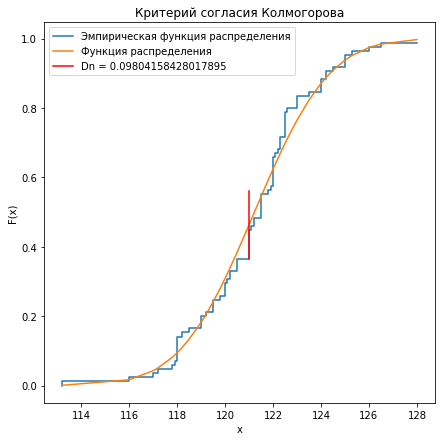

Dn: 0.9038987449345373
Уровень значимость: 0.1
Крит. область Dn > 1.2238734153404083
p-value: 0.3902691297269861
Гипотеза H0 не отклоняется

Пример для сгенерированного exp:


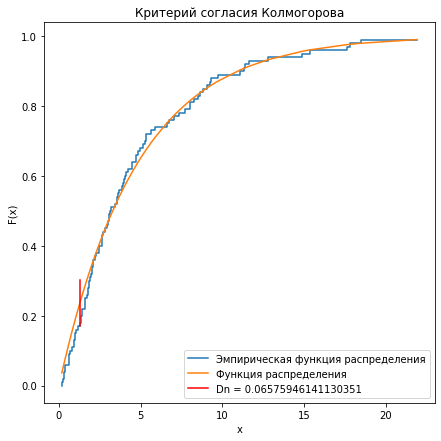

Dn: 0.6575946141130351
Уровень значимость: 0.1
Крит. область Dn > 1.2238734153404083
p-value: 0.842219868400482
Гипотеза H0 не отклоняется

Пример для сгенерированного uniform:


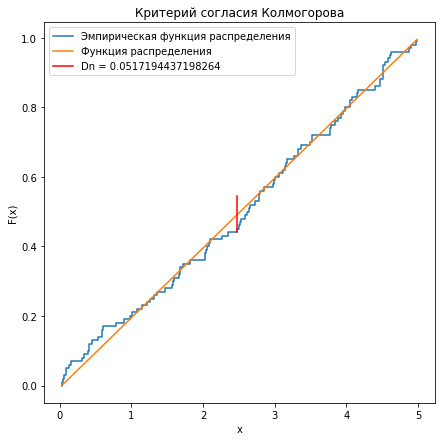

Dn: 0.517194437198264
Уровень значимость: 0.1
Крит. область Dn > 1.2238734153404083
p-value: 1.1713618061285123
Гипотеза H0 не отклоняется


In [6]:
X_data = data['Z1-4'].to_numpy()
X_data = X_data[~np.isnan(X_data)]

crit_kolmogorov(X_data, alp=0.1)
print('')
print('Пример для сгенерированного exp:')
crit_kolmogorov(np.random.exponential(5, 100), alp=0.1, distn='exp')
print('')
print('Пример для сгенерированного uniform:')
crit_kolmogorov(np.random.uniform(0, 5, 100), alp=0.1, distn='uniform') 